## Example: CLD on Sleep and Depressive symptoms
In our first example, we will implement a system dynamics model (SDM) analysis of a causal loop diagram (CLD) published as an example in the Education Corner article by Uleman et al (2024) doi: 10.1093/ije/dyae091.
This CLD focuses on the feedback loops between sleep and depressive symptoms in young adults.

In Kumu, the diagram looks as follows:

<img src="Kumu/Sleep CLD.jpg" alt="drawing" width="800"/>

To analyze this CLD, we will first run several initialization steps and import the Kumu file (which can be exported from the live Kumu page). Two adjustments are needed to this Kumu file. Firstly, in the 'Elements' sheet, the 'Type' column should specify for each variable whether they are an auxiliary, stock, or constant (see the manuscript for suggestions on how to select between these different variable types). Secondly, if Interaction terms have been identified in the system, these can be incorporated by adding a sheet called 'Interactions' (see our example).

The D2D method requires the user to specify several options, which are stored in a settings dataframe (s). These mandatory options are the time unit (months in this case), the end time (12 months), the time-step of interest (one month), and the variable of interest (depressive symptoms). The settings can be adjusted in the relevant json file in the Settings folder.

There are also several default settings that can be adjusted, namely the number of samples that should be drawn from the uncertain model parameters (N; 1000 by default) and the maximum parameter value for the regular parameters (0.2 by default) and the interaction term parameters (0.1 by default (1/2 of the maximum main effect parameters)). These parameters may have to be tuned a bit. If too high, the model may reach impossible values (e.g., infinity). The user can also decide whether or not to save the plots generated by this file and whether interventions should be run (both are True (1) by default).

When interaction terms are specified in the Kumu file, the user can set the setting 'interaction_terms' to 1 (True). If not, the interaction terms parameter will automatically set to False and the CLD will be interpreted as a linear system of equations. For linear systems, the user can decide whether to solve the equations analytically or numerically through the 'solve_analytically' setting (True by default for linear SDMs). The benefit of the algebraic solution is that it is more accurate (and faster, depending on the stepsize of the numerical solver).

In [1]:
# Initialize the settings and load relevant packages and modules
setting_name = 'Sleep'
%run ../initialize.py {setting_name} {None} 

Test for loading KUMU table passed.
Without interaction terms, double factor interventions are not meaningful. Setting double_factor_interventions to False.
Test comparison with vectorized implementation passed.
Test comparison analytic and numerical solution for linear model passed.
Test comparison with manual implementation for Sleep example passed.


/Users/dbw209/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/systemdynamics/systemdynamics/sdm.py:358: RuntimeWarning: invalid value encountered in scalar divide
  sign = np.sign(delta_target_respect_to_source/delta_source)  # np.sign(params[target][source])


In [2]:
## Print the main simulating settings
ns_dict = vars(s)
for sett in ["N", "time_unit", "t_end", "dt", "variable_of_interest", "max_parameter_value",
             "double_factor_interventions", "solve_analytically"]:
    print(sett, "=", ns_dict[sett])

N = 100
time_unit = Months
t_end = 12
dt = 1
variable_of_interest = Depressive_symptoms
max_parameter_value = 0.2
double_factor_interventions = 0
solve_analytically = 1


Given these settings, we can now run simulations from the SDM-converted CLD.

In [3]:
### Run simulations
df_sol_per_sample = []  # List for storing the solution dataframes
df_sol_per_sample_no_int = []   # List for storuing the solution dataframes without interventions
param_samples = {var : {} for var in s.intervention_variables}  # Dictionary for storing the parameters across samples

for num in tqdm(range(s.N)):  # Iterate over the number of samples
    df_sol = []

    params_i = sdm.sample_model_parameters() #s.intervention_auxiliaries)  # Sample model parameters

    for i, var in enumerate(s.intervention_variables):
        # Set the initial condition for the stocks to zero
        x0 = np.zeros(len(s.stocks_and_constants), order='F')  # By default no intervention on a stock or constant (initialized in equilibrium)
        intervention_auxiliaries = {}  # By default no intervention on an auxiliary
        params = deepcopy(params_i)  # Copy the parameters to avoid overwriting the original parameters

        if '+' in var:  # Double factor intervention
            var_1, var_2 = var.split('+')
            if var_1 in s.stocks_and_constants:  # Intervention on a stock or constant (first intervention variable)
                x0[s.stocks_and_constants.index(var_1)] += 1/2  # Increase the (baseline) value of the stock/constant by 1/2
            else:  # Intervention on an auxiliary
                params[var_1]["Intercept"] = 1/2
                #intervention_auxiliaries[var_1] = 1/2 # Select the auxiliary to get an intercept of 1/2 in sample_model_parameters function
            if var_2 in s.stocks_and_constants:
                x0[s.stocks_and_constants.index(var_2)] += 1/2  
            else:
                params[var_2]["Intercept"] = 1/2
                #intervention_auxiliaries[var_2] = 1/2
        else:  # Single factor intervention
            if var in s.stocks_and_constants:  # Intervention on a stock or constant (only variable)
                x0[s.stocks_and_constants.index(var)] += 1  # Increase the (baseline) value of the stock/constant by 1
            else:  # Intervention on an auxiliary (only variable)
                params[var]["Intercept"] = 1
                #intervention_auxiliaries[var] = 1  # Select the auxiliary to get an intercept of 1/2 in sample_model_parameters function
    
        # print("Intervention on", var)
        # print(new_params) #params)
        # print(x0)
        # print("----")

        new_params = sdm.make_equations_auxiliary_independent(params)  # Remove auxiliaries from the equations
        if np.sum([[1 for par in new_params[st] if par in s.auxiliaries] for st in new_params]) > 0:
            raise(Exception('Some parameters are defined for auxiliaries. This means the process of making equations auxiliary independent failed.',
                            'Likely because of a feedback loop with only auxiliaries. Please ensure that all feedback loops contain at least one stock.'))
        A, K, b = sdm.get_A_and_K_matrices()  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
        df_sol_per_intervention = sdm.run_SDM(x0, A, K, b)
        df_sol += [df_sol_per_intervention]

        # Store the model parameters
        if num == 0: 
            param_samples[var] = {target : {source : [params[target][source]] for source in params[target]} for target in params}
        else:
            for target in params:
                for source in params[target]:
                    param_samples[var][target][source] += [params[target][source]]

    df_sol_per_sample += [df_sol]


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


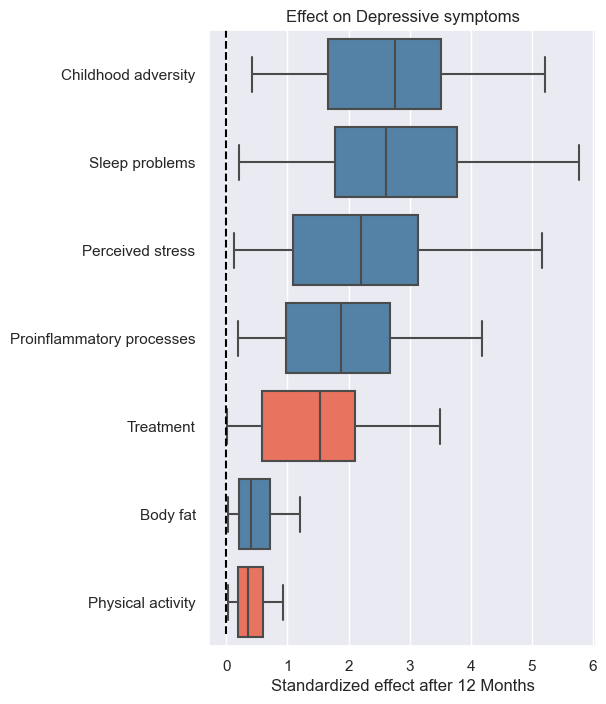

In [4]:
top = None  # Top factors to show
intervention_effects = sdm.get_intervention_effects(df_sol_per_sample)
plot_simulated_intervention_ranking(intervention_effects, s, top_plot=top)

if s.save_results:
    title = 'simulated_interventions_ranking_plots_per_individual_N' + str(s.N) + '.jpg'
    plt.savefig(os.path.join("Results", curr_time + '_' + setting_name + "/" + title), format='jpg', dpi=300)

In [5]:
## Plot settings
s.interval_type = "percentile" # "confidence", "percentile", "spaghetti"
s.confidence_bounds = .95

# Reorder df_sol_per_sample according to the intervention effects
plot_int_eff = dict(sorted(intervention_effects.items(),
                                        key=lambda item: np.median(np.abs(item[1])), reverse=True))
plot_int_eff = {int : plot_int_eff[int] for int in list(plot_int_eff.keys())[:top]}
top_vars_plot = list(plot_int_eff.keys())

df_sol_per_sample_reordered = df_sol_per_sample.copy()
for i in range(s.N):
    df_sol_per_sample_dict_i = dict(zip(s.intervention_variables, df_sol_per_sample[i]))
    df_sol_per_sample_reordered[i] = [df_sol_per_sample_dict_i[var] for var in top_vars_plot]

# Plot the simulated interventions
# plot_simulated_interventions(df_sol_per_sample_reordered, top_vars_plot, "Simulated interventions with N="+ str(s.N) + " samples", s)

# if s.save_results:
#     title = 'simulated_interventions_plots_per_individual_N' + str(s.N) + '.jpg'
#     plt.savefig(os.path.join("Results", curr_time + '_' + setting_name + "/" + title), format='jpg', dpi=300)       

## Feedback loop analysis with Loops That Matter
Currently only works correctly for linear SDMs

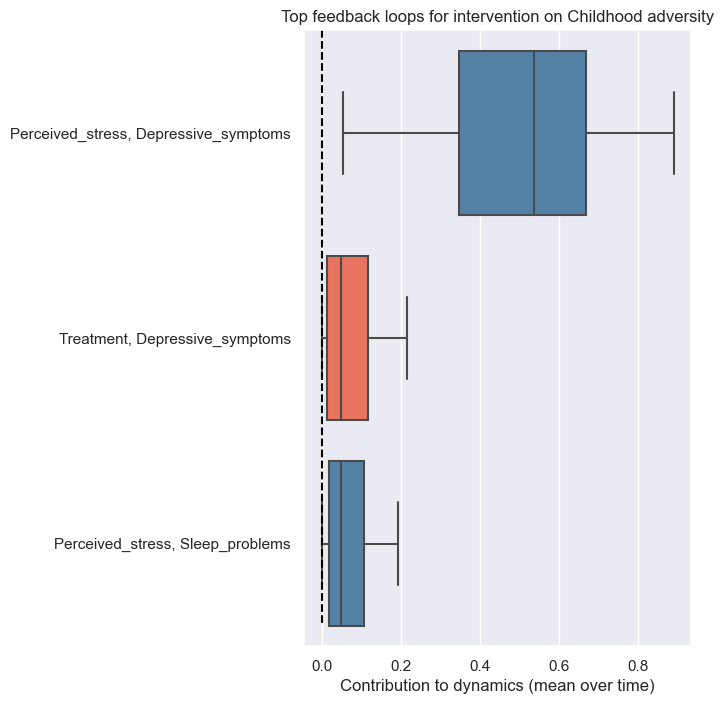

In [14]:
assert s.interaction_terms == False, "Interaction terms must be False for the feedback loop analysis."
### Combine the time values for the loop scores, either as the mean or the last value
combine_loop_type = 'mean'  #'final'  'mean'
cut_off_importance = 0.09  # 0.005  # Select most important loops to plot
int_var = top_vars_plot[0]  # Select an intervention for which we will assess the feedback loop dominance
j = s.intervention_variables.index(int_var)

## Get the right loop scores for specific intervention
linkscores_per_sample = []
loopscores_per_sample = []
loopscores_combined_per_sample = []
for k in range(s.N):
    df_i = df_sol_per_sample[k][j]
    params = {target : {source : param_samples[int_var][target][source][k] for source in param_samples[int_var][target]} for target in param_samples[int_var]}
    linkscores = sdm.get_link_scores(df_i, params)
    loopscores, feedback_loops = sdm.get_loop_scores(linkscores)
    linkscores_per_sample += [linkscores]
    loopscores_per_sample += [loopscores]

    if combine_loop_type == "mean":
        loopscores_combined_over_time = {loop : np.mean(loopscores[loop]) for loop in loopscores}
    elif combine_loop_type == "final":
        loopscores_combined_over_time = {loop : loopscores[loop][-1] for loop in loopscores}
    else:
        raise ValueError("combine_loop_type must be either 'mean' or 'final'.") 
    
    loopscores_combined_per_sample += [loopscores_combined_over_time]

loopscores_combined_per_sample = {loop : [loopscores_combined_per_sample[k][loop] for k in range(s.N)] for loop in loopscores_combined_per_sample[0]}

df_loops = pd.DataFrame(loopscores_combined_per_sample)
df_loops = df_loops.loc[:, df_loops.mean().abs() > cut_off_importance]  # Plot only the most relevant loops
df_loops = df_loops.reindex(columns=list(
                    df_loops.abs().median().sort_values(ascending=False).index))

palette_dict = {var : "#4682B4" for var in df_loops.columns}  # Blue for positive effects
medians = df_loops.median()
lower_than_zero_vars = medians.loc[medians < 0].index
for var in lower_than_zero_vars:
    palette_dict[var] = "#FF6347"  # Red for negative effects
    
plot_feedback_loops_ranking(df_loops, int_var, combine_loop_type, palette_dict)

if s.save_results:
    title = 'feedback_loop_ranking_intervention_on_' + int_var +'_N_'+ str(s.N) + '.jpg'
    plt.savefig(os.path.join("Results", curr_time + '_' + setting_name + "/" + title), format='jpg', dpi=300)       


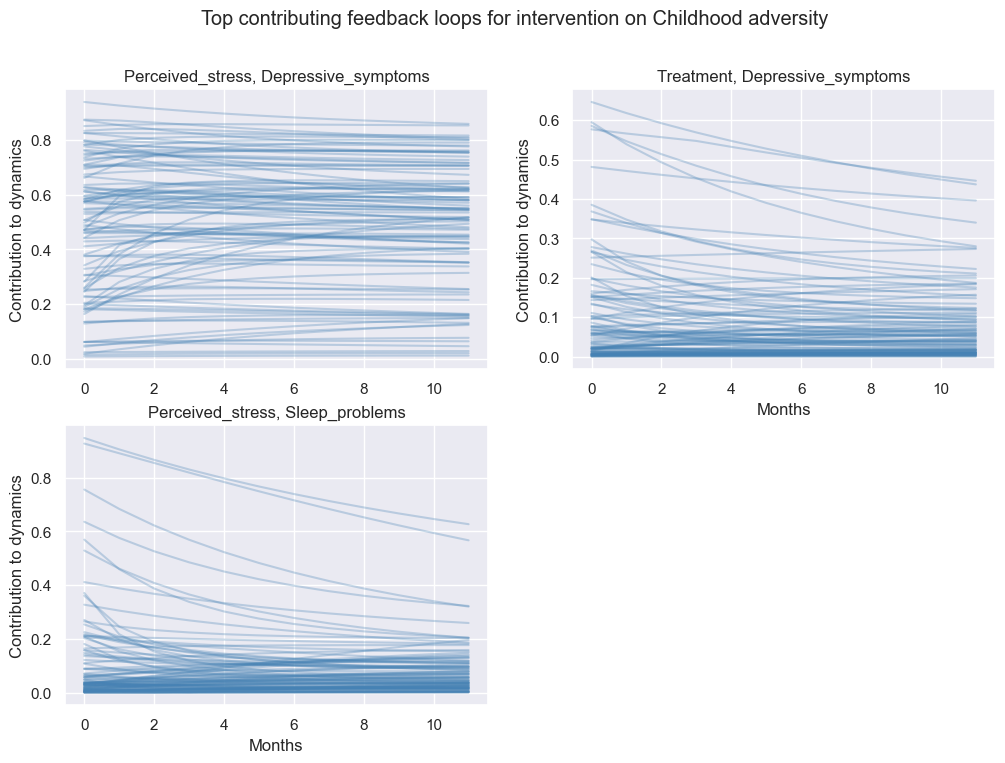

In [15]:
plot_feedback_loops_over_time(s, df_loops, loopscores_per_sample, int_var, palette_dict)
#plot_feedback_loops_over_time_bounds(s, df_loops, loopscores_per_sample, int_var, palette_dict)

if s.save_results:
    title = 'feedback_loops_importance_over_time_intervention_on_' + int_var +'_N_'+ str(s.N) + '.jpg'
    plt.savefig(os.path.join("Results", curr_time + '_' + setting_name + "/" + title), format='jpg', dpi=300)       


## Sensitivity analysis

In [16]:
## Estimate spearman correlation for all model parameters (sensitivity analysis)
def flatten(xss):
    return [x for xs in xss for x in xs]

SA_mode = "top"  # Average over 'all' interventions or pick only the 'top'

if SA_mode == "all":
    loop_over = s.intervention_variables
elif SA_mode == "top":
    loop_over = [top_vars_plot[0]]
else:
    raise(ValueError("SA_mode must be either 'all' or 'top'."))

param_names = flatten([[source+"->"+target for source in param_samples[s.intervention_variables[0]][target]] for target in param_samples[s.intervention_variables[0]]])
df_SA = pd.DataFrame(columns=param_names+["Effect"])

for int_var in loop_over:
    i = s.intervention_variables.index(int_var)
    for n in range(s.N):
        params_curr = flatten([[param_samples[int_var][target][source][n] for source in param_samples[int_var][target]] for target in param_samples[int_var]])
        eff_size = abs(df_sol_per_sample[n][i].loc[df_sol_per_sample[n][i].Time==s.t_eval[-1], s.variable_of_interest])  # Absolute effect size
        new_row = np.array(params_curr + [float(eff_size.iloc[0])])
        df_SA_new = pd.DataFrame(new_row, index=param_names+["Effect"]).T
        df_SA = pd.concat([df_SA, df_SA_new], ignore_index=True)

## Top ranked model parameters across the interventions (with respect to the effect on depressive symptoms)
df_SA.corr('spearman').abs()['Effect'][[p for p in param_names if "Intercept" not in p]].sort_values(ascending=False)

Childhood_adversity->Depressive_symptoms          0.605905
Perceived_stress->Depressive_symptoms             0.439448
Childhood_adversity->Perceived_stress             0.390915
Depressive_symptoms->Perceived_stress             0.164896
Proinflammatory_processes->Depressive_symptoms    0.154947
Sleep_problems->Perceived_stress                  0.140414
Depressive_symptoms->Proinflammatory_processes    0.105563
Proinflammatory_processes->Sleep_problems         0.100282
Perceived_stress->Sleep_problems                  0.094053
Sleep_problems->Body_fat                          0.087693
Physical_activity->Proinflammatory_processes      0.086313
Body_fat->Proinflammatory_processes               0.082760
Depressive_symptoms->Treatment                    0.079076
Body_fat->Sleep_problems                          0.073639
Depressive_symptoms->Physical_activity            0.034179
Physical_activity->Body_fat                       0.029631
Perceived_stress->Proinflammatory_processes       0.0223